In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import urllib
from bs4 import BeautifulSoup
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

sns.set()
%matplotlib inline

# This checks if the notebook is executed on Kaggle or on your local machine and
# acts accordingly with filenames. On Kaggle the dataset is already managed by a managed
# and downloaded to (URLs are linked) a dataset there.
try:
    os.environ['KAGGLE_DATA_PROXY_TOKEN']
except KeyError:
    # daily infections in Germany
    url_daily_corona = "https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv"

    # infections per 100k residents in German states
    url_corona_bl_100k = "https://opendata.arcgis.com/datasets/ef4b445a53c1406892257fe63129a8ea_0.csv"

    # infections per 100k residents in German provinces
    url_corona_provinces = "https://opendata.arcgis.com/datasets/917fc37a709542548cc3be077a786c17_0.csv"

    fname1 = "./RKI_covid19_daily_de.csv"
    fname2 = "./RKI_covid19_states_100k.csv"
    fname3 = "./RKI_covid19_provinces_100k.csv"

    urllib.request.urlretrieve(url_daily_corona, fname1)
    urllib.request.urlretrieve(url_daily_corona, fname2)
    urllib.request.urlretrieve(url_daily_corona, fname3)
    
    fname4 = "./additional_data/covid19_events_measures.csv"
    
else:
    dirname = "/kaggle/input/covid19-data-germany-robert-koch-institute/"
    dirname_additional = "/kaggle/input/additional-covid19-data/additional_data/"
    # daily infections in Germany
    fname1 = dirname + "dd4580c810204019a7b8eb3e0b329dd6_0.csv"

    # infections per 100k residents in German states
    fname2 = dirname + "ef4b445a53c1406892257fe63129a8ea_0.csv"

    # infections per 100k residents in German provinces
    fname3 = dirname + "917fc37a709542548cc3be077a786c17_0.csv"
    
    fname4 = dirname_additional + "covid19_events_measures.csv"


df_daily_data = pd.read_csv(fname1, parse_dates=["Meldedatum"], date_parser=lambda ts: pd.Timestamp(ts).strftime('%Y-%m-%d'))
df_measures_events = pd.read_csv(fname4, parse_dates=["Date"])

df_daily_data.sort_values(['Meldedatum'], inplace=True)
df_measures_events.sort_values(['Date'], inplace=True)

In [2]:
df_daily_data

,ObjectId,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
173097,41264065,9,Bayern,LK Starnberg,A35-A59,M,1,0,2020-01-28,9188,"06.10.2020, 00:00 Uhr",0,-9,2020/01/27 00:00:00,0,1,1,Nicht übermittelt
167335,41258303,9,Bayern,LK Landsberg a.Lech,A15-A34,M,1,0,2020-01-28,9181,"06.10.2020, 00:00 Uhr",0,-9,2020/01/23 00:00:00,0,1,1,Nicht übermittelt
155684,41246652,9,Bayern,SK München,A15-A34,W,1,0,2020-01-29,9162,"06.10.2020, 00:00 Uhr",0,-9,2020/01/23 00:00:00,0,1,1,Nicht übermittelt
165893,41256861,9,Bayern,LK Fürstenfeldbruck,A15-A34,M,1,0,2020-01-29,9179,"06.10.2020, 00:00 Uhr",0,-9,2020/01/25 00:00:00,0,1,1,Nicht übermittelt
173456,41264424,9,Bayern,LK Traunstein,A00-A04,W,1,0,2020-01-31,9189,"06.10.2020, 00:00 Uhr",0,-9,2020/01/29 00:00:00,0,1,1,Nicht übermittelt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35925,41126893,5,Nordrhein-Westfalen,SK Mönchengladbach,A80+,M,1,0,2020-10-05,5116,"06.10.2020, 00:00 Uhr",1,-9,2020/10/05 00:00:00,-9,0,0,Nicht übermittelt
104765,41195733,7,Rheinland-Pfalz,LK Westerwaldkreis,A15-A34,W,1,0,2020-10-05,7143,"06.10.2020, 00:00 Uhr",1,-9,2020/10/01 00:00:00,-9,0,1,Nicht übermittelt
104707,41195675,7,Rheinland-Pfalz,LK Westerwaldkreis,A15-A34,M,1,0,2020-10-05,7143,"06.10.2020, 00:00 Uhr",1,-9,2020/09/27 00:00:00,-9,0,1,Nicht übermittelt
35719,41126687,5,Nordrhein-Westfalen,SK Mönchengladbach,A35-A59,W,1,0,2020-10-05,5116,"06.10.2020, 00:00 Uhr",1,-9,2020/09/24 00:00:00,-9,0,1,Nicht übermittelt


In [3]:
print("Measures taken and events/incidents concerning Covid19."
      + "These might show a connection to the falling or rising of the curves:")
df_measures_events

Measures taken and events/incidents concerning Covid19.These might show a connection to the falling or rising of the curves:


,Date,In_Short,State,Description
0,2020-03-16,"Schools, day care centers closed.",Alle,"Schools, day care centers closed."
1,2020-03-16,Entry bans and strict border controls.,Alle,Germany has decided on entry bans and strict c...
2,2020-03-20,"Quarantine Bavaria, only vital locations open.",Bayern,"Only vital location, like supermarkets, doctor..."
3,2020-03-22,"Quarantine country-wide, only vital locations ...",Alle,"Only vital location, like supermarkets, doctor..."


In [4]:
print("Total sum of cases in Germany:")
df_daily_data["AnzahlFall"].sum()

Total sum of cases in Germany:


303230

In [5]:
print("Describe number of cases per day in Germany:")
df_daily_data.groupby("Meldedatum").sum()["AnzahlFall"].describe()

Describe number of cases per day in Germany:


count     235.000000
mean     1290.340426
std      1374.087269
min         1.000000
25%       425.500000
50%       805.000000
75%      1613.000000
max      6555.000000
Name: AnzahlFall, dtype: float64

In [6]:
# def annotationsForDate(df, date):
#     """
#     Takes the measures df and a time index and returns all the short
#     measure descriptions as a string for the annotations below
#     """
#     query = df_measures_events.query("Date == '{}'".format(date))
#     ann = ""
#     for i in query.index:
#         state = ""
#         if query["State"].iloc[i]:
#             state = query["State"].iloc[i] + ": "
#         s = query["In_Short"].iloc[i]
#         ann += s + '\n'
#     return ann.rstrip()

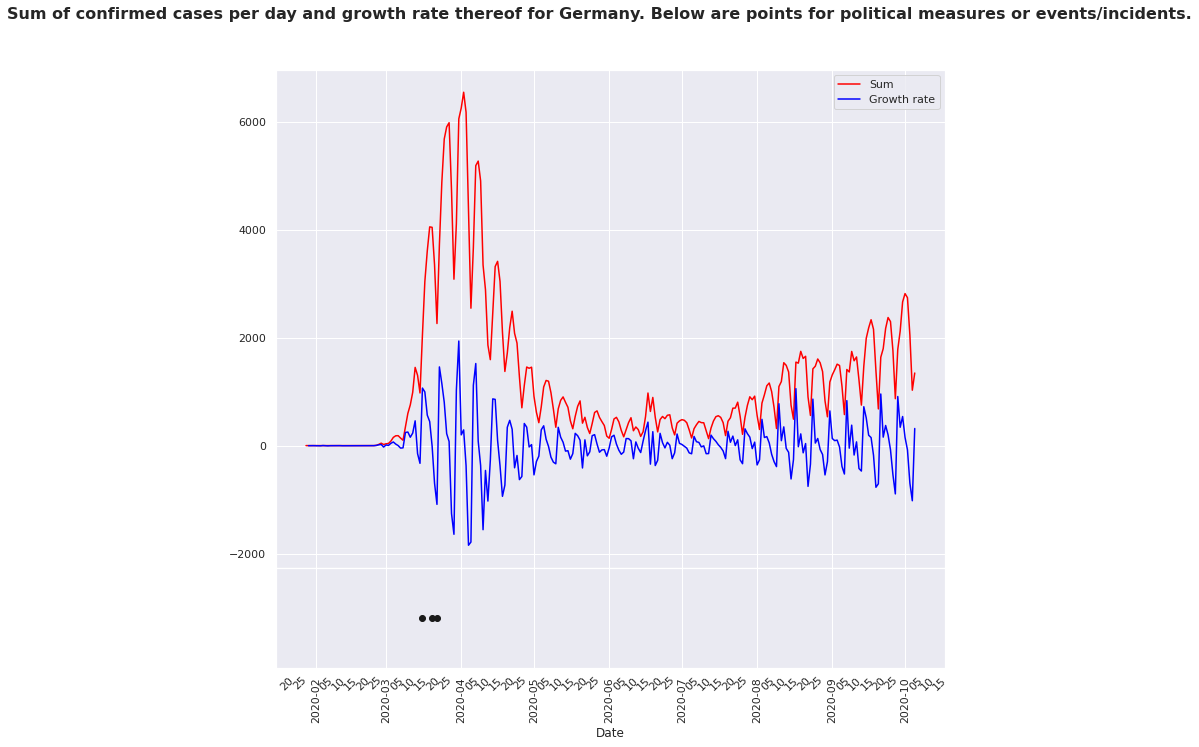

In [7]:
gr_day_reported = df_daily_data.groupby('Meldedatum')

# TODO: make these relative to screen size somehow
figsize = (12,11)
fig, ax = plt.subplots(2, 1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios': [5, 1]})
fig.subplots_adjust(hspace=0.0)
suptitel_attr = {"fontsize" : 16, "fontweight" : "bold", "ha" : "center", "va" : "bottom", "y" : 0.94}

# set plot stuff
fig.suptitle("Sum of confirmed cases per day and growth rate thereof for Germany. Below are points "
             + "for political measures or events/incidents.", **suptitel_attr)

for axis in ax.flat:
    axis.set_xlabel('Date')
    rule = mpl.dates.rrulewrapper(mpl.dates.MONTHLY,  bymonthday=(5, 10, 15, 20, 25))
    axis.xaxis.set_minor_locator(mpl.dates.RRuleLocator(rule))
    axis.xaxis.set_minor_formatter(mpl.dates.DateFormatter("%d"))
    axis.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonthday=1))
    axis.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m'))

ax[1].yaxis.set_minor_locator(mpl.ticker.NullLocator())
ax[1].yaxis.set_major_locator(mpl.ticker.NullLocator())

sum_cases_per_day = gr_day_reported['AnzahlFall'].sum()
growth_rate = sum_cases_per_day.diff()

ax[0].plot(sum_cases_per_day, color='red', label='Sum')
ax[0].plot(growth_rate, color='blue', label='Growth rate')

plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax[0].xaxis.get_minorticklabels(), rotation=45)


for d in df_measures_events["Date"].unique():
    #s = annotationsForDate(df_measures_events, d)
    #axs[1].annotate(s = "bla", xy=(d, sum_cases_per_day[d]), xytext=(-50,-10), xycoords="data")
    pass

ax[1].scatter(df_measures_events["Date"].unique(), len(df_measures_events["Date"].unique()) * [100], c='k')

for axis in ax.flat:
    plt.setp(axis.xaxis.get_majorticklabels(), rotation=90)
    plt.setp(axis.xaxis.get_minorticklabels(), rotation=45)

ax[0].legend()

Text(0.5, 1, 'Cases per day per age class')

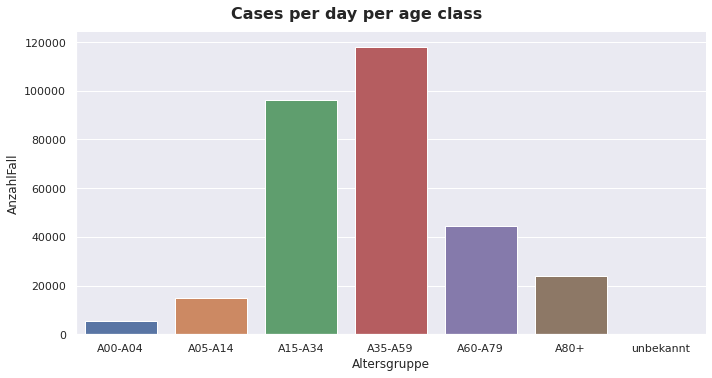

In [8]:
g_ages = df_daily_data.groupby("Altersgruppe")
ages_cases = g_ages["AnzahlFall"].sum().reset_index()
cp = sns.catplot("Altersgruppe", "AnzahlFall", data=ages_cases, kind="bar", aspect = 2)
suptitel_attr = {"fontsize" : 16, "fontweight" : "bold", "ha" : "center", "va" : "bottom", "y" : 1}
cp.fig.suptitle("Cases per day per age class", **suptitel_attr)

In [9]:
print("Total sum of cases per German state")
df_daily_data.groupby(['Bundesland'])["AnzahlFall"].sum()

Total sum of cases per German state


Bundesland
Baden-Württemberg         51180
Bayern                    70005
Berlin                    15943
Brandenburg                4447
Bremen                     2631
Hamburg                    8339
Hessen                    20109
Mecklenburg-Vorpommern     1293
Niedersachsen             21281
Nordrhein-Westfalen       73840
Rheinland-Pfalz           11215
Saarland                   3449
Sachsen                    7533
Sachsen-Anhalt             2764
Schleswig-Holstein         4978
Thüringen                  4223
Name: AnzahlFall, dtype: int64

In [10]:
print("Describe sum of daily cases per day per German state.")
df_daily_data.groupby(['Bundesland', "Meldedatum"])['AnzahlFall'].sum().unstack().T.fillna(0).describe().round(decimals=0)

Describe sum of daily cases per day per German state.


Bundesland,Baden-Württemberg,Bayern,Berlin,Brandenburg,Bremen,Hamburg,Hessen,Mecklenburg-Vorpommern,Niedersachsen,Nordrhein-Westfalen,Rheinland-Pfalz,Saarland,Sachsen,Sachsen-Anhalt,Schleswig-Holstein,Thüringen
count,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0
mean,218.0,298.0,68.0,19.0,11.0,35.0,86.0,6.0,91.0,314.0,48.0,15.0,32.0,12.0,21.0,18.0
std,287.0,398.0,66.0,26.0,13.0,45.0,76.0,8.0,89.0,265.0,53.0,27.0,46.0,15.0,26.0,20.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,36.0,60.0,22.0,3.0,3.0,3.0,27.0,0.0,28.0,128.0,11.0,1.0,3.0,2.0,3.0,3.0
50%,101.0,137.0,50.0,8.0,8.0,17.0,64.0,2.0,67.0,231.0,29.0,5.0,14.0,7.0,14.0,10.0
75%,288.0,371.0,88.0,22.0,15.0,48.0,128.0,6.0,114.0,424.0,62.0,14.0,43.0,14.0,28.0,25.0
max,1421.0,1985.0,343.0,136.0,108.0,210.0,329.0,50.0,410.0,1207.0,271.0,171.0,250.0,78.0,117.0,85.0


In [11]:
# Get daily cases and growth rate per German state

loc_unknown_col = "-nicht erhoben-"
state_names = df_daily_data['Bundesland'].unique()
# remove column name for unknown location of the case
index = np.where(state_names == loc_unknown_col)
state_names = np.delete(state_names, index)

states_daily = df_daily_data.groupby(['Meldedatum', 'Bundesland'])['AnzahlFall'].sum()
df_per_state_daily = pd.DataFrame()
for state in state_names:
    df_per_state_daily[state] = states_daily.unstack()[state].fillna(0)

In [12]:
# TODO: make these relative to screen size somehow
figsize = (19,16)
ax_label_fontsize = 10.0
legend_fontsize = 8.0
major_tick_fontsize = 8.0
minor_tick_fontsize = 7.0
tick_monthdays = (10, 20)

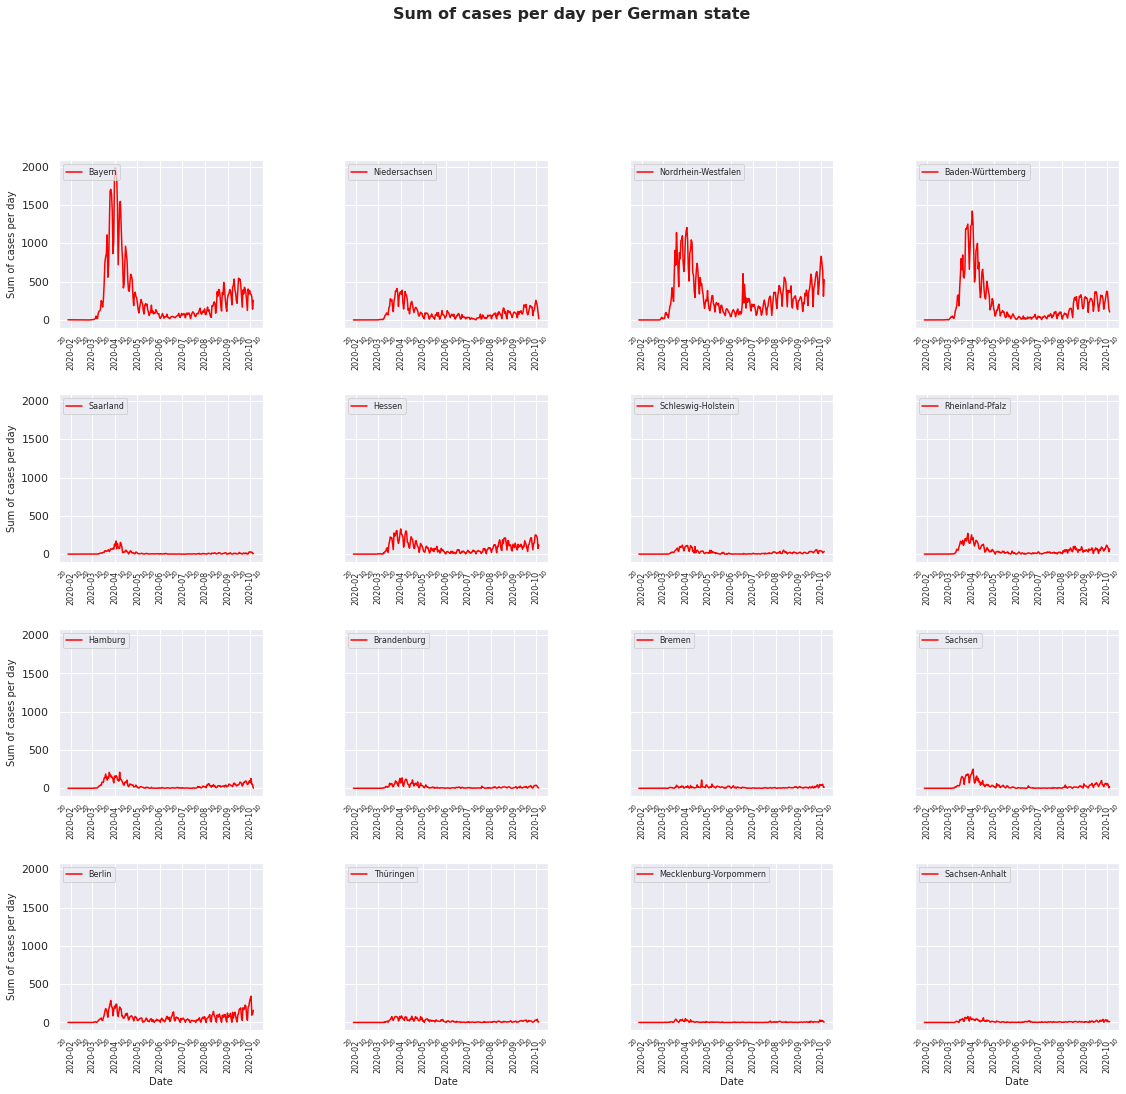

In [13]:
# Plot sum of confirmed cases per day per German state

fig, ax = plt.subplots(4, 4, sharey=True, figsize=figsize)
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

fig.suptitle("Sum of cases per day per German state", **suptitel_attr)

for axis in ax.flat:
    rule = mpl.dates.rrulewrapper(mpl.dates.MONTHLY,  bymonthday=tick_monthdays)
    axis.xaxis.set_minor_locator(mpl.dates.RRuleLocator(rule))
    axis.xaxis.set_minor_formatter(mpl.dates.DateFormatter("%d"))
    axis.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonthday=1))
    axis.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m'))
    
    for tick in axis.xaxis.get_major_ticks():
            tick.label.set_fontsize(tick_fontsize)

for plt_row in ax:
    plt_row[0].set_ylabel('Sum of cases per day', fontsize=ax_label_fontsize)
    
for column_plots in ax.T:
    column_plots[-1].set_xlabel('Date', fontsize=ax_label_fontsize)
    
ix = 0
for subp in ax.flat:
    state = state_names[ix]
    subp.plot(df_per_state_daily[state], color='red', label = "{}".format(state))
    subp.legend(fontsize=legend_fontsize, loc="upper left")
    plt.setp(subp.xaxis.get_majorticklabels(), rotation=90)
    plt.setp(subp.xaxis.get_minorticklabels(), rotation=45)
    for tick in subp.xaxis.get_major_ticks():
            tick.label.set_fontsize(major_tick_fontsize)
    for tick in subp.xaxis.get_minor_ticks():
            tick.label.set_fontsize(minor_tick_fontsize)
    ix += 1
        

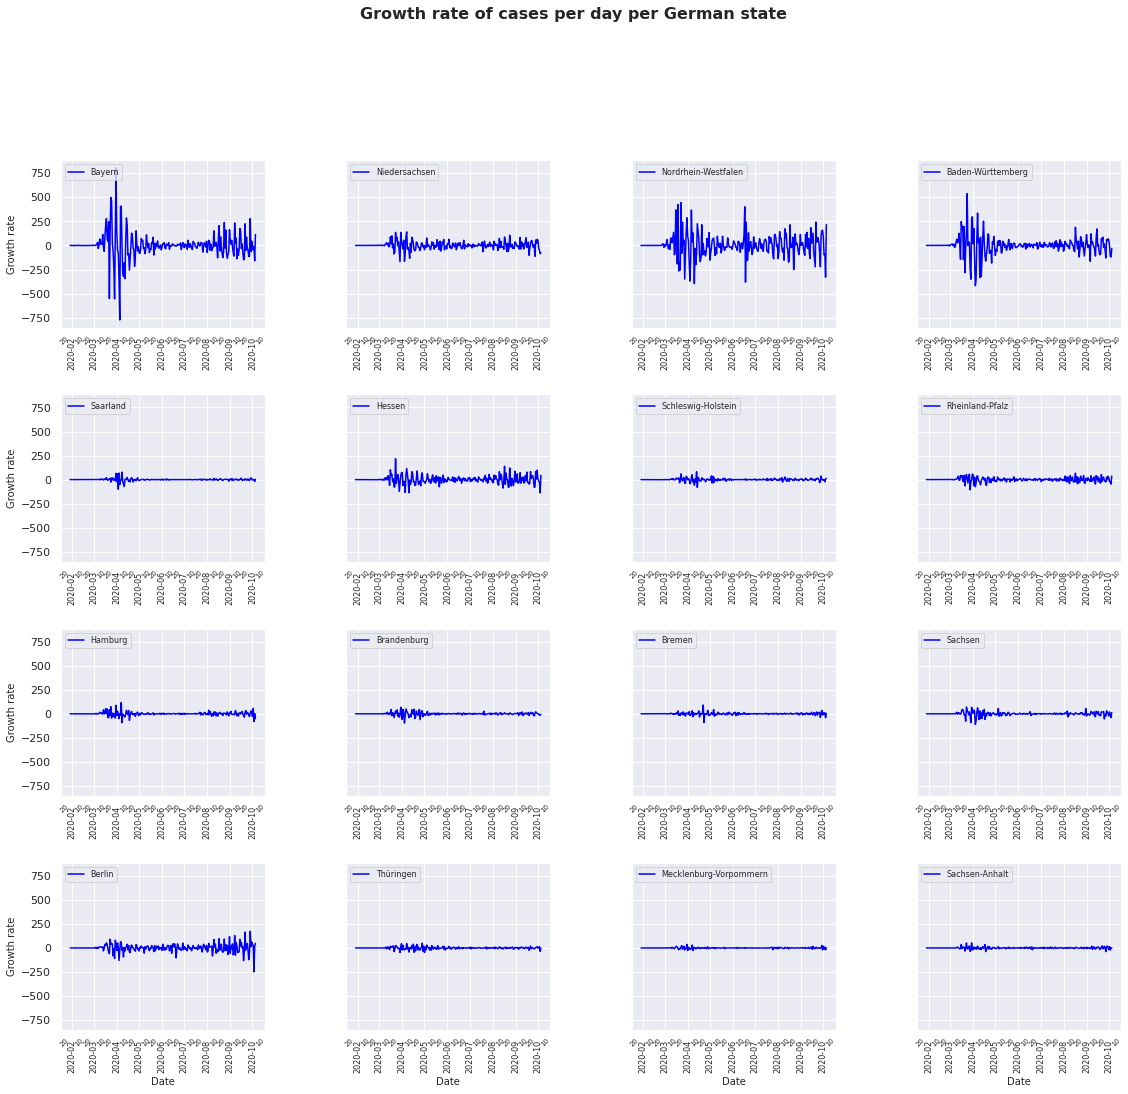

In [14]:
# Plot growth rate of daily confirmed cases per German state

fig, ax = plt.subplots(4, 4, sharey=True, figsize=figsize)
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

fig.suptitle("Growth rate of cases per day per German state", **suptitel_attr)

for axis in ax.flat:
    rule = mpl.dates.rrulewrapper(mpl.dates.MONTHLY,  bymonthday=tick_monthdays)
    axis.xaxis.set_minor_locator(mpl.dates.RRuleLocator(rule))
    axis.xaxis.set_minor_formatter(mpl.dates.DateFormatter("%d"))
    axis.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonthday=1))
    axis.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m'))
    
    for tick in axis.xaxis.get_major_ticks():
            tick.label.set_fontsize(tick_fontsize)

for plt_row in ax:
    plt_row[0].set_ylabel('Growth rate', fontsize=ax_label_fontsize)
    
for column_plots in ax.T:
    column_plots[-1].set_xlabel('Date', fontsize=ax_label_fontsize)
    
ix = 0
for subp in ax.flat:
    state = state_names[ix]
    subp.plot(df_per_state_daily[state].diff(), color='blue', label = "{}".format(state))
    subp.legend(fontsize=legend_fontsize, loc="upper left")
    plt.setp(subp.xaxis.get_majorticklabels(), rotation=90)
    plt.setp(subp.xaxis.get_minorticklabels(), rotation=45)
    for tick in subp.xaxis.get_major_ticks():
            tick.label.set_fontsize(major_tick_fontsize)
    for tick in subp.xaxis.get_minor_ticks():
            tick.label.set_fontsize(minor_tick_fontsize)
    ix += 1

## Test reports: Visualize number of tests positive / negative results

### Download reports

In [15]:
def download_pdf(link, fname, dl_dir = "test_reports/"):
    urllib.request.urlretrieve(link, dl_dir + fname)

link_reports = "https://ars.rki.de/Content/COVID19/Main.aspx"